In [238]:
%load_ext autoreload
%autoreload 2

import os
import re
import dask.dataframe as dd
import pandas as pd
import numpy as np
import csv
from newspaper import Article
from articleDateExtractor import extractArticlePublishedDate
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
from bs4 import BeautifulSoup
from helpers import functions

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
directory_con = 'data/conventional_data_pulls/'
directory_custom = 'data/custom_data_pulls/'

In [59]:
def concatenate_dataframes(pull_type, directory):
    """
    Concatenate all csv's and delete records with duplicate url's
    """
    # Year_month_day:
    pattern_date = '^\d{4}_\d{1,2}_\d{1,2}'

    # Short source name:
    pattern_source = '[a-z]+'
    
    # Starts with lower-case word and followed by letters/numbers/underscores (long source name):
    pattern_source_detail = '[a-z]+\w+'
    
    # Empty DataFrame to accumulate all csv's:
    df_master = pd.DataFrame()
    for filename in os.listdir(directory):
        # Skip non-csv's:
        if filename.endswith(".csv"):
            # Parse out date:
            pull_date = re.search(pattern_date, filename).group()
            pull_date = pd.to_datetime(pull_date, format='%Y_%m_%d')
            
            # Parse out short source name, e.g. 'rt':
            source = re.search(pattern_source, filename).group()
            if source == 'foxnews':
                source = 'fox'

            # And long source name, e.g. 'rt_main_page':
            source_detail = re.search(pattern_source_detail, filename).group()
            
            current_df = pd.read_csv(directory + filename)

            # Push pull_date and source name fields into the dataframe:
            current_df['source'] = source
            current_df['source_detail'] = source_detail
            current_df['pull_type'] = pull_type
            current_df['pull_date'] = pull_date

            # Accumulate frame:
            df_master = df_master.append(current_df, ignore_index=True)
            
            # Delete non-English RT sources (for conventional pulls only):
#             rt_filter = (df_master['source_url'] != 'http://actualidad.rt.com') & \
#                         (df_master['source_url'] != 'http://arabic.rt.com') & \
#                         (df_master['source_url'] != 'http://deutsch.rt.com') & \
#                         (df_master['source_url'] != 'http://francais.rt.com') & \
#                         (df_master['source_url'] != 'http://russian.rt.com') & \
#                         (df_master['source_url'] != 'http://rtd.rt.com')  # Exclude RT's documentary videos
#                         (df_master['source_url'] != 'http://rtd.rt.com')  # Exclude RT's documentary videos
#             df_master = df_master[rt_filter]

            # Clean up duplicates using 'canonical_link' and 'url':
            df_master.drop_duplicates(subset=['canonical_link', 'url'], keep='first', inplace=True)
    return df_master

In [44]:
# %%time
# df_conventional = concatenate_dataframes(pull_type='conventional', directory=directory_con)

CPU times: user 1min 19s, sys: 20.5 s, total: 1min 39s
Wall time: 1min 42s


In [90]:
%%time
df_custom = concatenate_dataframes(pull_type='custom', directory=directory_custom)

CPU times: user 1min 7s, sys: 13.6 s, total: 1min 20s
Wall time: 1min 22s


In [126]:
#df_custom.groupby('source').count()

,source_url,url,title,movies,text,keywords,meta_keywords,tags,authors,publish_date,...,rss_title,rss_link,rss_id,rss_published,rss_published_parsed,rss_feedburner_origlink,paper_section_name,source_detail,pull_type,pull_date
source,,,,,,,,,,,,,,,,,,,,,
bbc,797,797,797,797,797,797,797,797,797,0,...,797,797,797,797,797,797,797,797,797,797
cnn,939,939,939,939,939,939,939,939,939,0,...,939,939,939,939,939,939,939,939,939,939
fox,760,760,760,760,760,760,760,760,760,0,...,760,760,760,760,760,760,760,760,760,760
rt,831,831,831,831,831,831,831,831,831,0,...,831,831,831,831,831,831,831,831,831,831


In [93]:
#df_custom.groupby('source').count()

,source_url,url,title,movies,text,keywords,meta_keywords,tags,authors,publish_date,...,rss_title,rss_link,rss_id,rss_published,rss_published_parsed,rss_feedburner_origlink,paper_section_name,source_detail,pull_type,pull_date
source,,,,,,,,,,,,,,,,,,,,,
bbc,796,796,796,796,796,796,796,796,796,0,...,796,796,796,796,796,796,796,796,796,796
cnn,929,929,929,929,929,929,929,929,929,0,...,929,929,929,929,929,929,929,929,929,929
fox,760,760,760,760,760,760,760,760,760,0,...,760,760,760,760,760,760,760,760,760,760
rt,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


In [46]:
#df_master = pd.concat([df_conventional, df_custom], ignore_index=True)

In [48]:
#df_master.loc[3048, 'canonical_link'] = df_master.loc[3048, 'url']

In [49]:
#df_master['meta_data'] = df_master['meta_data'].astype(str)

### Work on filling RT publish dates:

In [61]:
def extract_rt_html_date(html_str):
    """
    Extracts based on html tag
    """
    soup = BeautifulSoup(html_str, 'html.parser')
    for item in soup.find_all('meta'):
        if item.get('name') == 'published_time_telegram':
            date_str = item.get('content', np.NaN)
            return pd.to_datetime(date_str)
    return np.nan

# def extract_rt_html_date_2(html_str):
#     """
#     """
#     soup = BeautifulSoup(html_str, 'html.parser')
#     for item in soup.find_all('span'):
#         if item.get('name') == 'published_time_telegram':
#             date_str = item.get('content', 'NotFound')
#             return pd.to_datetime(date_str)
#     return np.nan

def extract_rt_html_date_2(html_str):
    """
    Extracts based on text
    """
    regex = '[0-9]+\s[A-Za-z]+,\s[0-9]+'
    soup = BeautifulSoup(html_str, 'html.parser')
    for item in soup.find_all('span'):
        find_class = item.get('class', np.NaN)
        if find_class == ['date', 'date_article-header']:
            date_str = item.get_text()
            date_str = re.search(regex, date_str).group()
            return pd.to_datetime(date_str)
    return np.NaN

First pass:

In [91]:
rt_df = df_custom[df_custom.source == 'rt']

In [92]:
%%time
results_rt = rt_df['html'].apply(extract_rt_html_date)

CPU times: user 33.8 s, sys: 587 ms, total: 34.3 s
Wall time: 34.5 s


In [116]:
# Update the dataframe with discovered publish dates:
df_custom['publish_date'] = df_custom['publish_date'].fillna(results_rt)

In [182]:
results_rt.notnull().sum()

743

In [119]:
df_custom['publish_date'].isnull().sum()

2584

In [120]:
df_custom.shape

(3327, 27)

In [123]:
df_custom.groupby('source').count()

,source_url,url,title,movies,text,keywords,meta_keywords,tags,authors,publish_date,...,rss_title,rss_link,rss_id,rss_published,rss_published_parsed,rss_feedburner_origlink,paper_section_name,source_detail,pull_type,pull_date
source,,,,,,,,,,,,,,,,,,,,,
bbc,797,797,797,797,797,797,797,797,797,0,...,797,797,797,797,797,797,797,797,797,797
cnn,939,939,939,939,939,939,939,939,939,0,...,939,939,939,939,939,939,939,939,939,939
fox,760,760,760,760,760,760,760,760,760,0,...,760,760,760,760,760,760,760,760,760,760
rt,831,831,831,831,831,831,831,831,831,743,...,831,831,831,831,831,831,831,831,831,831


In [99]:
#df_master.loc[:, ('canonical_link', 'publish_date')][df_master.publish_date.notnull()].loc[2452].values

Second pass:

In [124]:
rest_rt_df = df_custom[(df_custom.source == 'rt') & (df_custom.publish_date.isnull())]

In [125]:
rest_rt_df.shape

(88, 27)

In [126]:
%%time
results_rest_rt = rest_rt_df['html'].apply(extract_rt_html_date_2)

CPU times: user 1.97 s, sys: 12 ms, total: 1.98 s
Wall time: 1.98 s


In [185]:
results_rest_rt.notnull().shape

(88,)

In [127]:
# Push the rest of the discovered dates in:
df_custom['publish_date'] = df_custom['publish_date'].fillna(results_rest_rt)

In [128]:
df_custom.publish_date.isnull().sum()

2496

### Work on filling out non-RT publish dates

In [143]:
def error_wrapper_date_parser(url):
    """
    """
    try:
        return extractArticlePublishedDate(url)
    except:
        return np.NaN

In [130]:
non_rt_df = df_custom[df_custom.source != 'rt']

In [131]:
nCores = cpu_count()
print('CPU Cores:', nCores)

CPU Cores: 8


In [16]:
%%time
dask_non_rt_df = dd.from_pandas(non_rt_df, npartitions=nCores)

CPU times: user 7.12 s, sys: 10.4 s, total: 17.5 s
Wall time: 29.7 s


In [145]:
%%time
results_non_rt = dask_non_rt_df['url'].map_partitions(lambda ser : ser.apply(error_wrapper_date_parser)).compute(scheduler='processes')

Extracting date from foo
Exception in extractArticlePublishedDate for foo
("unknown url type: 'foo'",)
Extracting date from foo
Exception in extractArticlePublishedDate for foo
("unknown url type: 'foo'",)
Extracting date from https://www.bbc.co.uk/news/business-47063405
Extracting date from https://www.bbc.co.uk/news/business-47066873
Extracting date from https://www.bbc.co.uk/news/business-47057870
Extracting date from https://www.cnn.com/2019/01/30/politics/shutdown-republicans-poll/index.html
Extracting date from https://www.bbc.co.uk/news/business-47055188
Extracting date from https://www.cnn.com/2019/01/30/politics/trump-foxconn-manufacturing/index.html
Extracting date from https://www.cnn.com/2019/01/30/politics/sarah-sanders-god-trump/index.html
Extracting date from https://www.cnn.com/2019/01/30/politics/donald-trump-reelection-numbers-2020/index.html
Extracting date from https://www.cnn.com/2019/01/30/politics/undocumented-worker-trump-state-of-the-union/index.html
Extracting

Extracting date from https://www.cnn.com/2019/01/30/tech/new-york-attorney-general-social-media/index.html
Extracting date from https://www.foxnews.com/world/japanese-police-launch-probe-into-an-online-sellers-effort-to-sell-apparent-uranium
Extracting date from https://www.foxnews.com/sports/super-bowl-liii-rams-vs-patriots
Extracting date from https://www.cnn.com/2019/01/30/tech/dhs-h1b-final-rule/index.html
Extracting date from https://www.bbc.co.uk/news/stories-47093041
Extracting date from https://www.foxnews.com/us/missing-kentucky-mom-taken-to-rural-home-police-say
Extracting date from https://www.foxnews.com/world/at-least-60-dead-in-boko-haram-attack-report
Extracting date from https://www.foxnews.com/us/border-patrol-agent-killed-while-on-duty-in-texas-officials
Extracting date from https://www.foxnews.com/politics/trump-picks-patriots-to-win-super-bowl-liii-while-poll-finds-half-a-country-doesnt-care-who-wins
Extracting date from https://www.cnn.com/2019/01/29/tech/facetime-

Extracting date from https://www.bbc.co.uk/news/world-us-canada-47143288
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47149342
Extracting date from https://www.cnn.com/2019/01/30/us/el-chapo-guzman-trial-closing-arguments/index.html
Extracting date from https://www.foxnews.com/tech/facebook-removes-accounts-of-fake-news-group-in-indonesia
Extracting date from https://www.bbc.co.uk/news/business-47054322
Extracting date from https://www.foxnews.com/tech/how-to-get-the-best-deals-on-macbook-ipad-and-iphone
Extracting date from https://www.bbc.co.uk/news/uk-england-humber-47102169
Extracting date from https://www.cnn.com/2019/01/30/sport/roger-goodell-super-bowl-liii-press-conference/index.html
Extracting date from https://www.foxnews.com/tech/from-apple-tv-to-roku-5-streaming-tv-devices-compared
Extracting date from https://www.bbc.co.uk/sport/football/46996820
Extracting date from https://www.foxnews.com/us/cow-shot-after-charging-police-officer-following-escape-fr

Extracting date from https://www.cnn.com/travel/article/shanghai-disneyland-zootopia/index.html
Extracting date from https://www.bbc.co.uk/news/uk-wales-47072503
Extracting date from https://www.cnn.com/travel/article/banana-island-qatar/index.html
Extracting date from https://www.bbc.co.uk/news/uk-politics-47143135
Extracting date from https://www.cnn.com/travel/article/japan-winter-stove-train-tsugaru/index.html
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47133868
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47150188
Extracting date from https://www.bbc.co.uk/news/world-latin-america-47101291
Extracting date from https://www.cnn.com/travel/article/igloo-hotel-davos-switzerland/index.html
Extracting date from https://www.bbc.co.uk/news/business-47124328
Extracting date from https://www.bbc.co.uk/news/business-46924999
Extracting date from https://www.cnn.com/travel/article/italy-town-pays-people-to-move-intl/index.html
Extracting date from 

Extracting date from https://www.bbc.co.uk/news/health-47150658
Extracting date from https://www.cnn.com/2019/01/29/europe/unhcr-mediterranean-migrant-deaths-intl/index.html
Extracting date from https://www.bbc.co.uk/news/newsbeat-47127298
Extracting date from https://www.bbc.co.uk/news/business-46985443
Extracting date from https://www.bbc.co.uk/news/technology-47069414
Extracting date from https://www.cnn.com/2019/01/29/asia/india-nuns-kerala-intl/index.html
Extracting date from https://www.bbc.co.uk/news/world-latin-america-47104508
Extracting date from https://www.cnn.com/2019/01/15/tech/alibaba-city-brain-hangzhou/index.html
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47114899
Extracting date from https://www.cnn.com/2019/01/26/intl_business/davos-divide/index.html
Extracting date from https://www.bbc.co.uk/sport/rugby-union/46799568
Extracting date from https://www.bbc.co.uk/news/business-47083972
Extracting date from https://www.bbc.co.uk/news/uk-england-w

Extracting date from https://www.bbc.co.uk/news/business-47137298
Extracting date from https://www.foxnews.com/health/tyson-recalls-36000-pounds-of-chicken-nuggets-after-complaints-about-rubber-in-product
Extracting date from https://www.foxnews.com/health/food-industry-sway-over-public-health-gets-new-scrutiny
Extracting date from https://www.bbc.co.uk/news/health-47115039
Extracting date from https://www.bbc.co.uk/news/uk-northern-ireland-foyle-west-47097135
Extracting date from https://www.bbc.co.uk/news/world-europe-47161500
Extracting date from https://www.bbc.co.uk/news/uk-wales-47127790
Extracting date from https://www.foxnews.com/health/woman-finds-baby-flies-living-in-forehead-after-trip-to-uganda
Extracting date from https://www.bbc.co.uk/news/world-australia-47038202
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47063423
Extracting date from https://www.foxnews.com/health/new-york-city-woman-sues-hospital-after-reported-confusion-over-end-of-life-support

Extracting date from https://www.foxnews.com/politics/pompeo-on-hannity-trump-kim-summit-februrary
Extracting date from https://www.bbc.co.uk/news/world-africa-47105774
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-46389081
Extracting date from https://www.foxnews.com/politics/sean-hannity-too-many-dems-support-infanticide-in-abortion-debate
Extracting date from https://www.bbc.co.uk/news/science-environment-47151778
Extracting date from https://www.bbc.co.uk/news/world-us-canada-47124189
Extracting date from https://www.foxnews.com/politics/white-house-explains-trump-putin-encounter-at-g20
Extracting date from https://www.bbc.co.uk/news/world-us-canada-47077141
Extracting date from https://www.foxnews.com/politics/sen-rand-paul-awarded-over-580g-after-he-was-attacked-by-neighbor
Extracting date from https://www.bbc.co.uk/news/uk-47135629
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47052136
Extracting date from https://www.foxnews.com/politic

Extracting date from https://www.cnn.com/2019/02/02/us/florida-orlando-airport-suicide-delays/index.html
Extracting date from https://www.foxnews.com/sports/los-angeles-rams-fans-frustrated-over-lack-of-jerseys-with-super-bowl-patch
Extracting date from https://www.bbc.co.uk/sport/football/47162391
Extracting date from https://www.bbc.co.uk/news/world-europe-47087874
Extracting date from https://www.bbc.co.uk/sport/formula1/47135129
Extracting date from https://www.cnn.com/2019/01/31/us/navy-first-female-flyover-rosemary-mariner-trnd/index.html
Extracting date from https://www.foxnews.com/sports/super-bowl-underdogs-have-recent-history-on-their-side
Extracting date from https://www.bbc.co.uk/news/technology-47144449
Extracting date from https://www.bbc.co.uk/sport/football/47024468
Extracting date from https://www.cnn.com/2019/02/02/entertainment/bow-wow-arrest/index.html
Extracting date from https://www.foxnews.com/sports/former-all-pro-linebacker-had-most-severe-form-of-cte-when-he-d

Extracting date from https://www.cnn.com/2019/01/31/politics/nyt-trump-talks-waste-time/index.html
Extracting date from https://www.bbc.co.uk/sport/football/47116930
Extracting date from https://www.foxnews.com/us/strangers-surprise-missouri-family-living-without-heat-in-polar-vortex-after-hearing-heartbreaking-story
Extracting date from https://www.bbc.co.uk/news/technology-47146431
Extracting date from https://www.bbc.co.uk/news/world-europe-47087875
Extracting date from https://www.cnn.com/2019/02/02/us/hawaiian-flight-33-turn-back/index.html
Extracting date from https://www.foxnews.com/us/new-mexico-woman-says-she-keeps-getting-pee-covered-bologna-from-stranger
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47027442
Extracting date from https://www.bbc.co.uk/news/uk-england-oxfordshire-47135608
Extracting date from https://www.cnn.com/travel/article/groundhog-day-punxsutawney-phil-prediction/index.html
Extracting date from https://www.bbc.co.uk/sport/american-fo

Extracting date from https://www.bbc.co.uk/news/health-46994187
Extracting date from https://wnep.com/2019/02/01/frigid-weather-perfect-for-ice-festival-in-lewisburg/
Extracting date from https://www.cnn.com/2019/02/01/entertainment/spongebob-super-bowl-tribute/index.html
Extracting date from https://www.foxnews.com/world/uae-ceremony-celebrating-strides-in-gender-diversity-mocked-for-having-no-women-in-attendance
Extracting date from https://www.bbc.co.uk/news/science-environment-47121399
Extracting date from https://abc7chicago.com/officers-removed-from-chicago-school-after-stun-gun-used-on-student/5118201/
Extracting date from https://www.bbc.co.uk/news/world-us-canada-47149918
Extracting date from https://herald-review.com/news/local/year-old-dead-after-explosion-levels-home-northeast-of-sullivan/article_a989c773-f5cc-5343-96ed-677253a36919.html
Extracting date from https://www.foxnews.com/world/manitoba-mayor-apologizes-for-vulgar-statement-involving-justin-trudeau-and-a-pipeline-

Extracting date from https://www.bbc.co.uk/news/world-us-canada-47140458
Extracting date from https://www.foxnews.com/lifestyle/minnesota-college-student-viral-shorts-bitter-cold
Extracting date from https://www.bbc.co.uk/news/uk-england-cornwall-47148868
Extracting date from https://www.cnn.com/2019/02/01/health/london-newborn-baby-park-scli-gbr-intl/index.html
Extracting date from https://www.foxnews.com/food-drink/villa-italian-kitchen-trolls-fyre-festival-pizza-slice
Extracting date from https://www.cnn.com/2019/02/01/health/sw-social-media-exercise/index.html
Extracting date from https://www.foxnews.com/auto/1969-ford-torino-gt-cobra-jet-that-was-parked-for-44-years-is-a-dirty-charmer
Extracting date from https://www.bbc.co.uk/news/uk-northern-ireland-47058629
Extracting date from https://www.bbc.co.uk/news/uk-england-london-47132760
Extracting date from https://www.bbc.co.uk/news/business-47094767
Extracting date from https://www.bbc.co.uk/news/uk-england-beds-bucks-herts-4712443

Extracting date from https://www.foxnews.com/us/police-break-up-rowdy-snow-day-near-west-virginia-university
Extracting date from https://www.bbc.co.uk/news/world-us-canada-47124195
Extracting date from https://www.foxnews.com/us/tsa-officer-dies-at-orlando-airport-after-jumping-from-hotel-into-atrium-all-flights-briefly-halted-report
Extracting date from https://www.bbc.co.uk/news/uk-scotland-glasgow-west-47039141
Extracting date from https://www.cnn.com/2019/02/01/politics/epa-new-board-members-climate-denier/index.html
Extracting date from https://www.cnn.com/2019/02/01/politics/donald-trump-2020-election/index.html
Extracting date from https://www.foxnews.com/us/dramatic-video-captures-arizona-inmate-taking-librarian-hostage-at-prison
Extracting date from https://www.bbc.co.uk/sport/av/football/47148498
Extracting date from https://www.cnn.com/2019/02/01/asia/frontier-services-xinjiang-intl/index.html
Extracting date from https://www.bbc.co.uk/news/world-us-canada-47123137
Extracti

Extracting date from https://www.bbc.co.uk/news/uk-47013914
Extracting date from https://www.bbc.co.uk/news/business-47046979
Extracting date from https://www.cnn.com/2019/02/06/politics/maxine-waters-steven-mnuchin-russia/index.html
Extracting date from https://www.cnn.com/2019/02/01/politics/donald-trump-kamala-harris-2020/index.html
Extracting date from https://www.cnn.com/2019/02/06/us/denver-teachers-strike/index.html
Extracting date from https://www.cnn.com/2019/02/06/media/jill-abramson-book-allegations/index.html
Extracting date from https://www.bbc.co.uk/news/world-latin-america-47163940
Extracting date from https://www.cnn.com/2019/02/01/politics/us-russia-nuclear-arms-treaty-pompeo/index.html
Extracting date from https://www.bbc.co.uk/news/business-47108099
Extracting date from https://www.cnn.com/2019/02/05/entertainment/liam-neeson-gma/index.html
Extracting date from https://www.bbc.co.uk/news/world-middle-east-47118889
Extracting date from https://www.cnn.com/2019/02/04/e

Extracting date from https://www.bbc.co.uk/news/blogs-news-from-elsewhere-47156397
Extracting date from https://www.cnn.com/2019/02/06/us/el-chapo-guzman-jury-deliberations-day-three/index.html
Extracting date from https://www.cnn.com/2019/02/05/politics/trump-contractors-border-wall-national-emergency/index.html
Extracting date from https://www.cnn.com/2019/01/31/tech/foxconn-wisconsin/index.html
Extracting date from https://www.cnn.com/2019/02/03/entertainment/superbowl-halftime-show/index.html
Extracting date from https://www.bbc.co.uk/news/business-47063053
Extracting date from https://www.cnn.com/2019/02/04/entertainment/demi-lovato-21-savage/index.html
Extracting date from https://www.cnn.com/2019/02/06/politics/john-dingell-tweet/index.html
Extracting date from https://www.cnn.com/2019/02/05/politics/donald-trump-state-of-the-union-speech/index.html
Extracting date from https://www.cnn.com/2019/02/06/business/eddie-lampert-sears-ceo/index.html
Extracting date from https://www.bb

Extracting date from https://www.cnn.com/2019/02/07/health/juul-nicotine-arms-race-study/index.html
Extracting date from https://bleacherreport.com/articles/2818771-lindsey-vonn-announces-retirement-from-professional-skiing
Extracting date from https://www.cnn.com/2019/02/07/health/trump-generic-drug-approvals-partner/index.html
Extracting date from https://www.cnn.com/2019/02/05/politics/ivanka-vacuuming/index.html
Extracting date from https://www.cnn.com/2019/02/01/media/nfl-super-bowl-iii/index.html
Extracting date from https://www.cnn.com/2019/02/04/politics/ralph-northam-2020-democrats/index.html
Extracting date from https://www.bbc.co.uk/news/health-47057341
Extracting date from https://www.cnn.com/2019/02/07/health/beer-before-wine-fine-myth-study/index.html
Extracting date from https://www.cnn.com/2019/02/06/politics/house-intelligence-transcripts-mueller/index.html
Extracting date from https://www.cnn.com/2019/02/01/sport/super-bowl-liii-preview-rams-patriots/index.html
Extrac

Extracting date from https://www.cnn.com/2019/02/04/americas/venezuela-maduro-trump-intl/index.html
Extracting date from https://bleacherreport.com/articles/2819593-college-football-preseason-top-25-ranking-post-2019-national-signing-day
Extracting date from https://www.cnn.com/2019/02/06/business/tesla-model-3-price-cut/index.html
Extracting date from https://www.cnn.com/2019/02/07/politics/alexandria-ocasio-cortez-ed-markey-green-new-deal/index.html
Extracting date from https://www.cnn.com/2019/02/05/politics/2020-democrats-state-of-the-union-guests/index.html
Extracting date from https://www.bbc.co.uk/news/health-41483322
Extracting date from https://www.cnn.com/2019/02/04/us/21-savage-arrest-ice/index.html
Extracting date from https://www.cnn.com/2019/01/31/opinions/state-of-the-union-trump-pelosi-zelizer/index.html
Extracting date from https://www.cnn.com/2019/02/07/opinions/karen-pence-art-therapy-opinion-dantonio/index.html
Extracting date from https://www.cnn.com/2019/02/04/pol

Extracting date from https://www.cnn.com/interactive/2019/02/middleeast/yemen-lost-us-arms/
Extracting date from https://www.bbc.co.uk/news/uk-wales-politics-46991474
Extracting date from https://www.cnn.com/travel/article/bangkok-new-chinatown/index.html
Extracting date from https://www.cnn.com/2019/02/05/politics/democrats-2020-defeating-trump/index.html
Extracting date from https://www.cnn.com/2019/02/04/politics/joe-lieberman-ralph-northam-cnntv/index.html
Extracting date from https://www.cnn.com/2019/02/01/us/howard-thurman-mlk-gandhi/index.html
Extracting date from https://www.bbc.co.uk/news/world-us-canada-47066659
Extracting date from https://www.cnn.com/2019/02/07/politics/trump-health/index.html
Extracting date from https://www.cnn.com/2019/02/04/politics/trump-border-wall/index.html
Extracting date from https://www.cnn.com/2019/02/01/us/btc-lost-boy-hathaway-found-first-responders-gingras/index.html
Extracting date from https://www.cnn.com/2019/02/07/politics/roger-stone-gag

Extracting date from https://www.bbc.co.uk/news/blogs-the-papers-47111597
Extracting date from https://www.cnn.com/2019/02/07/tech/amazon-facial-recognition-defense/index.html
Extracting date from https://www.bbc.co.uk/news/health-47095251
Extracting date from https://www.stltoday.com/news/local/crime-and-courts/st-louis-man-gets-years-for-kidnapping-rape-of-washington/article_02589cd0-71cf-5531-a33c-64d1389588a5.html
Extracting date from https://newyork.cbslocal.com/2019/02/05/home-alone-mom-delivers-baby-girl-by-herself-in-new-jersey/
Extracting date from https://www.cnn.com/2019/02/04/tech/amazon-hq2-new-york-backlash/index.html
Extracting date from https://www.cnn.com/2019/02/07/tech/apple-facetime-bug-fix/index.html
Extracting date from https://www.ktbs.com/news/arklatex-indepth/school-bathroom-layout-from-s-causes-concern-for-arkansas-father/article_74165a2c-28cc-11e9-a09e-d3bd5af2f60a.html
Extracting date from https://www.cnn.com/2019/02/07/tech/postmates-ipo/index.html
Extracti

Extracting date from https://www.cnn.com/2019/01/30/sport/ronnie-wood-grand-national-horse-racing-sport-intl/index.html
Extracting date from https://www.cnn.com/travel/article/asia-new-hotels-opening-2019/index.html
Extracting date from https://www.cnn.com/travel/article/dubai-top-beauty-spots/index.html
Extracting date from https://www.cnn.com/2018/12/28/us/frugal-social-worker-leaves-millions-to-charity-trnd/index.html
Extracting date from https://www.cnn.com/2019/02/04/health/brain-age-sex-differences-study/index.html
Extracting date from https://www.bbc.co.uk/news/in-pictures-47073703
Extracting date from https://www.cnn.com/2019/01/29/motorsport/formula-1-formula-e-merger-mercedes-spt-intl/index.html
Extracting date from https://www.cnn.com/2019/02/05/opinions/loss-trust-american-democracy-crisis-marx-woodson/index.html
Extracting date from https://www.bbc.co.uk/news/technology-47056759
Extracting date from https://www.cnn.com/2019/01/10/us/bus-driver-saves-baby-trnd/index.html
Ex

Extracting date from https://www.foxnews.com/health/colorado-woman-who-claimed-hospital-removed-healthy-kidneys-dies-9-months-later
Extracting date from https://fox43.com/2019/02/04/woman-accused-of-causing-second-degree-burns-to-daughters-face/
Extracting date from https://www.bbc.co.uk/news/uk-scotland-scotland-politics-47071376
Extracting date from https://www.foxnews.com/entertainment/kid-rock-blasts-detroit-paper-following-report
Extracting date from https://www.wsbtv.com/news/local/atlanta/metro-atlanta-family-fulfills-dying-father-s-wish-to-attend-super-bowl/914728831
Extracting date from https://www.foxnews.com/health/woman-left-suffering-from-full-body-rash-swollen-lips-for-weeks-due-to-hive-disorder
Extracting date from https://www.bbc.co.uk/news/world-europe-47055734
Extracting date from https://www.foxnews.com/health/mom-who-lost-ear-to-skin-cancer-claims-tanning-as-teen-led-to-disease
Extracting date from https://www.wdrb.com/news/bardstown-pizza-delivery-driver-gets-tip-f

Extracting date from https://wnep.com/2019/02/06/man-sorry-for-capturing-and-trying-to-sell-rattlesnakes/
Extracting date from https://www.foxnews.com/opinion/gutfeld-on-last-nights-address
Extracting date from https://miami.cbslocal.com/2019/02/04/smoke-in-cockpit-forces-aa-flight-to-return-to-miami/
Extracting date from https://abc13.com/masked-clowns-arrested-for-machete-attack-in-texas-city/5124230/
Extracting date from https://www.foxnews.com/health/pro-athlete-18-swallows-toothpick-in-sandwich-and-nearly-dies-officials-say
Extracting date from https://www.cnn.com/2019/02/05/business/us-china-trade-war-europe/index.html
Extracting date from https://www.wesh.com/article/at-least-2-dozen-animals-dead-after-fire-at-orange-county-wildlife-sanctuary/26128761
Extracting date from https://fox11online.com/news/local/some-of-worlds-best-windsurfers-compete-in-fond-du-lac-area
Extracting date from https://www.foxnews.com/politics/james-clyburn-virginia-allegations-deserve-due-process
Extrac

Extracting date from https://www.cnn.com/style/article/wearing-white-sotu-meaning/index.html
Extracting date from https://www.cnn.com/travel/article/antonov-an-225-kiev-ukraine/index.html
Extracting date from https://www.foxnews.com/science/ancient-bible-reportedly-recovered-from-smugglers-in-turkey
Extracting date from https://www.foxnews.com/entertainment/lauren-blanchard-extends-final-exam-winning-streak
Extracting date from https://www.cnn.com/2019/01/04/sport/south-africa-womens-team-babalwa-latsha-spt-intl/index.html
Extracting date from https://www.bbc.co.uk/sport/football/47111521
Extracting date from https://www.foxnews.com/entertainment/armie-hammer-addresses-his-white-privilege-discusses-stan-lee-backlash
Extracting date from https://www.foxnews.com/science/new-insect-discovered-in-canada-may-be-survivor-from-the-last-ice-age
Extracting date from https://www.foxnews.com/entertainment/jesse-watters-slams-call-to-eradicate-billionaires
Extracting date from https://www.foxnews.

Extracting date from https://www.foxnews.com/food-drink/drinkable-chips-designed-to-keep-phone-grease-free-prompt-mixed-reactions
Extracting date from https://www.foxnews.com/entertainment/cardi-b-talks-possibility-of-having-another-baby-with-husband-offset-its-not-that-easy
Extracting date from https://www.foxnews.com/auto/f-150-harley-davidson-edition-returns-but-not-from-ford
Extracting date from https://www.foxnews.com/sports/former-texas-nfl-player-vince-young-arrested-on-dwi-charges
Extracting date from https://www.foxnews.com/entertainment/meghan-markles-sister-samantha-markle-releasing-two-books
Extracting date from https://www.foxnews.com/lifestyle/bride-asks-guests-for-233-to-secure-their-place-at-the-wedding-that-is-the-tackiest-thing-i-have-ever-heard
Extracting date from https://www.foxnews.com/food-drink/ihop-debuting-pizza-inspired-pancizzas-in-honor-of-national-pizza-day
Extracting date from https://www.foxnews.com/auto/photos-hint-at-an-elon-musk-cameo-in-the-upcoming-

Extracting date from https://www.foxnews.com/politics/judge-grills-mueller-team-on-claim-manafort-lied-prosecutors-say-issues-at-heart-of-russia-probe
Extracting date from https://www.foxnews.com/food-drink/chick-fil-a-at-mercedes-benz-stadium-transformed-into-completely-different-eatery-on-super-bowl-sunday
Extracting date from https://www.foxnews.com/politics/ocasio-cortez-acknowledges-her-privilege-as-cisgendered-woman
Extracting date from https://www.foxnews.com/us/reward-offered-after-texas-woman-setting-up-garage-sale-is-killed
Extracting date from https://www.foxnews.com/politics/whitaker-will-testify-before-house-panel-tense-back-forth-nadler
Extracting date from https://www.bbc.co.uk/news/blogs-trending-47056039
Extracting date from https://www.foxnews.com/politics/elizabeth-warren-apologizes-to-cherokee-nation-over-taking-dna-test-to-prove-native-american-roots
Extracting date from https://www.foxnews.com/food-drink/burger-kings-super-bowl-ad-andy-warhol-was-taken-from-1982-f

Extracting date from https://www.foxnews.com/science/dark-energy-gets-weirder-mysterious-force-may-vary-over-time
Extracting date from https://www.foxnews.com/sports/frank-robinson-hall-of-fame-baseball-player-and-first-african-american-mlb-manager-dead-at-83
Extracting date from https://www.foxnews.com/politics/class-warrior-elizabeth-warren-worth-millions-new-financial-records-show
Extracting date from https://www.foxnews.com/world/china-investigating-treatment-possibly-tainted-with-hiv-reports-say
Extracting date from https://www.foxnews.com/sports/nba-star-harrison-barnes-reacts-to-news-that-he-was-traded-during-game
Extracting date from https://www.foxnews.com/science/aruba-based-photographer-captures-osprey-carrying-off-vibrant-blue-coral-reef-fish-stunning-images-show
Extracting date from https://www.bbc.co.uk/news/uk-politics-47108445
Extracting date from https://www.foxnews.com/politics/northam-rivals-campaign-blames-gop-group-for-not-finding-racist-yearbook-photo
Extracting d

Extracting date from https://www.foxnews.com/sports/lindsey-vonn-crashes-during-final-super-g-event-of-her-career-at-world-championships-in-sweden
Extracting date from https://www.foxnews.com/us/photos-show-purse-phone-savannah-spurlock-was-carrying-the-night-she-disappeared
Extracting date from https://www.bbc.co.uk/news/newsbeat-47107639
Extracting date from https://www.foxnews.com/us/schiff-hires-ex-national-security-council-staff-for-panel
Extracting date from https://www.foxnews.com/science/mysterious-island-that-formed-in-the-pacific-ocean-is-here-to-stay
Extracting date from https://www.foxnews.com/sports/patriots-owner-robert-kraft-praises-rupert-murdoch-for-elevating-the-nfl
Extracting date from https://www.foxnews.com/world/work-begins-to-remove-mammoth-fatberg-under-british-town
Extracting date from https://www.foxnews.com/us/man-charged-with-running-over-atlanta-officer-arrested
Extracting date from https://www.foxnews.com/science/shock-warning-on-melting-glaciers-in-the-hi

Extracting date from https://www.foxnews.com/world/south-hopeful-wary-but-nuke-talks-crucial-for-korean-ties
Extracting date from https://www.foxnews.com/tech/atts-fake-5g-logo-now-on-iphones-too
Extracting date from https://www.foxnews.com/tech/youtube-recommended-self-harm-videos-to-children-as-young-as-13
Extracting date from https://www.foxnews.com/world/un-reduces-meetings-on-kosovo-under-us-europe-pressure
Extracting date from https://www.foxnews.com/tech/nest-security-cameras-watch-illinois-family-as-company-blames-compromised-passwords
Extracting date from https://www.bbc.co.uk/news/world-africa-47108139
Extracting date from https://www.foxnews.com/world/mexico-astronomers-reduce-use-of-research-sites-due-to-crime
Extracting date from https://www.foxnews.com/tech/quitting-facebook-might-make-you-happier-but-dumber-study
Extracting date from https://www.foxnews.com/tech/got-an-iphone-x-try-on-warby-parker-glasses-at-home
Extracting date from https://www.foxnews.com/sports/los-an

Extracting date from https://www.foxnews.com/tech/army-tests-new-communication-device-that-could-save-wounded-soldiers-lives
Extracting date from https://www.bbc.co.uk/news/business-47155720
Extracting date from https://www.foxnews.com/us/alleged-nyc-subway-shooter-suspected-ms-13-member-was-in-us-illegally-ice-says
Extracting date from https://www.foxnews.com/us/virginia-state-trooper-dies-after-suspect-opened-fire-during-raid
Extracting date from https://www.cnn.com/us/live-news/super-bowl-2019-updates/index.html
Extracting date from https://www.foxnews.com/us/supreme-court-halts-louisiana-abortion-clinic-law-for-now
Extracting date from https://www.foxnews.com/us/fox-news-first-trump-slams-bad-for-country-pelosi-northam-under-pressure-to-resign-over-racist-pic
Extracting date from https://www.foxnews.com/us/trump-to-call-for-unity-at-state-of-the-union-while-dems-push-disunity-dems-dilemma-in-northam-scandal
Extracting date from https://www.foxnews.com/us/texas-man-37-gets-60-years-

Extracting date from https://www.foxnews.com/world/paris-building-fire-death-toll-rises-to-10-arson-eyed
Extracting date from https://www.bbc.co.uk/news/stories-46964969
Extracting date from https://www.cnn.com/2019/02/03/cnn10/ten-content-mon/index.html
Extracting date from https://www.foxnews.com/world/russia-must-develop-new-missile-systems-in-response-to-us-withdrawal-from-arms-control-treaty-russia-top-minister-says
Extracting date from https://www.foxnews.com/world/pope-francis-celebrates-first-ever-papal-mass-in-united-arab-emirates
Extracting date from https://www.bbc.co.uk/news/business-47157411
Extracting date from https://www.cnn.com/2019/02/03/opinions/presidential-weekly-briefing-sotu-threats-vinograd/index.html
Extracting date from https://www.bbc.co.uk/news/science-environment-47030057
Extracting date from https://www.bbc.co.uk/news/business-47144762
Extracting date from https://www.cnn.com/2019/02/03/football/premier-league-arsenal-manchester-city-manchester-united-leic

Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47147570
Extracting date from https://www.bbc.co.uk/news/science-environment-46960842
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47144368
Extracting date from https://www.bbc.co.uk/news/world-asia-46943593
Extracting date from https://www.wkbw.com/news/local-news/amherst-and-buffalo-police-officers-honored-for-lifting-vehicle-freeing-woman-trapped-beneath
Extracting date from https://www.fox4now.com/news/local-news/punta-gorda-day-care-worker-charged-with-child-abuse
Extracting date from https://www.3newsnow.com/news/local-news/nsp-seizes-189-pounds-of-marijuana-during-i-80-stop
Extracting date from https://www.wnem.com/news/baby-born-at-saginaw-homeless-shelter/article_7115e778-2694-11e9-af52-475ed88778f2.html
Extracting date from https://www.bbc.co.uk/news/entertainment-arts-47143399
Extracting date from https://www.bbc.co.uk/news/science-environment-46951152
Extracting date from https://www.kt

Extracting date from https://www.cnn.com/2019/01/30/entertainment/ariana-grande-tattoo/index.html
Extracting date from https://www.cnn.com/2019/01/30/entertainment/maroon-5-travis-scott-big-boi-halftime-performance-what-to-know/index.html
Extracting date from https://www.cnn.com/2019/01/29/entertainment/reactions-jussie-smollett/index.html
Extracting date from https://www.cnn.com/2019/01/30/entertainment/celine-dion-thin/index.html
Extracting date from https://www.cnn.com/2019/01/30/entertainment/gwyneth-paltrow-lawsuit-skiing/index.html
Extracting date from https://www.cnn.com/2019/01/29/entertainment/netflix-hulu-amazon-february/index.html
Extracting date from https://www.cnn.com/2019/01/30/entertainment/nick-cannon-wendy-williams-show/index.html
Extracting date from https://www.cnn.com/2019/01/29/entertainment/netflix-ted-bundy/index.html
Extracting date from https://www.cnn.com/2019/01/30/entertainment/bts-v-song-scenery/index.html
Extracting date from https://www.cnn.com/2019/01/2

Extracting date from https://www.cnn.com/2019/01/30/politics/homeland-security-chairman-subpoena-nielsen/index.html
CPU times: user 6.97 s, sys: 16 s, total: 23 s
Wall time: 11min 30s


In [189]:
results_non_rt.notnull().sum()

2419

In [165]:
# Some time standards conversion:
results_non_rt_converted = pd.to_datetime(results_non_rt, utc=True)
results_non_rt_converted = results_non_rt_converted.dt.tz_localize(None)

In [191]:
df_custom['publish_date'] = df_custom['publish_date'].fillna(results_non_rt_converted)

In [196]:
# 77 makes sense
df_custom['publish_date'].isnull().sum()

77

In [214]:
df_custom.groupby('source').count()

,source_url,url,title,movies,text,keywords,meta_keywords,tags,authors,publish_date,...,rss_title,rss_link,rss_id,rss_published,rss_published_parsed,rss_feedburner_origlink,paper_section_name,source_detail,pull_type,pull_date
source,,,,,,,,,,,,,,,,,,,,,
bbc,797,797,797,797,797,797,797,797,797,795,...,797,797,797,797,797,797,797,797,797,797
cnn,939,939,939,939,939,939,939,939,939,928,...,939,939,939,939,939,939,939,939,939,939
fox,760,760,760,760,760,760,760,760,760,696,...,760,760,760,760,760,760,760,760,760,760
rt,831,831,831,831,831,831,831,831,831,831,...,831,831,831,831,831,831,831,831,831,831


In [234]:
%%time
# Back_up
df_custom.to_csv('data/2019_02_09_analysis.csv')

CPU times: user 47.3 s, sys: 10.3 s, total: 57.7 s
Wall time: 1min 9s


In [230]:
data = [go.Histogram(x=df_custom.publish_date)]

In [231]:
plotly.offline.iplot({
    "data": data,
    "layout": go.Layout(title="hello world")
})

### Analysis

In [235]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### Preprocess:

In [243]:
%%time
# Basic text cleaning:
df_custom['clean_text'] = df_custom['text'].apply(functions.clean_text_string,
                                                  keep_dbl_newline=False) 

CPU times: user 2.09 s, sys: 26.6 ms, total: 2.12 s
Wall time: 2.14 s


In [236]:
# Enable stop words, for later clearing:
stop_words = stopwords.words('english')
# "bbc radio live" appears often, so add that to stop words; 'may' also seem turn up a lot, but not mean much:
stop_words.extend(['also', 'bbc', 'radio', 'live', 'may'])

In [244]:
# Convert our text strings to list:
data = df_custom.clean_text.values.tolist()

In [251]:
# Extra text cleaning, just in case:

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [253]:
data_words = list(functions.sent_to_words(data))

#### Remove Stopwords, Make Bigrams/Trigrams and Lemmatize:

In [255]:
# Define functions for stopwords, bigrams, trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [256]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [258]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=70) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=70)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/Users/alexander/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



CPU times: user 40.3 s, sys: 229 ms, total: 40.6 s
Wall time: 40.6 s


In [259]:
%%time
# Form Bigrams and Trigrams:
data_words_trigrams = make_trigrams(data_words_nostops)

CPU times: user 7.34 s, sys: 108 ms, total: 7.44 s
Wall time: 7.54 s


In [260]:
%%time
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

CPU times: user 4min 57s, sys: 12.7 s, total: 5min 10s
Wall time: 1min 22s


#### Create the Dictionary and Corpus needed for Topic Modeling:

In [261]:
%%time
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#### Building LDA Model:

In [262]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        #model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [263]:
%%time

# Can take a long time to run.
model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=1)

CPU times: user 1h 52min 39s, sys: 6min 15s, total: 1h 58min 55s
Wall time: 2h 58s


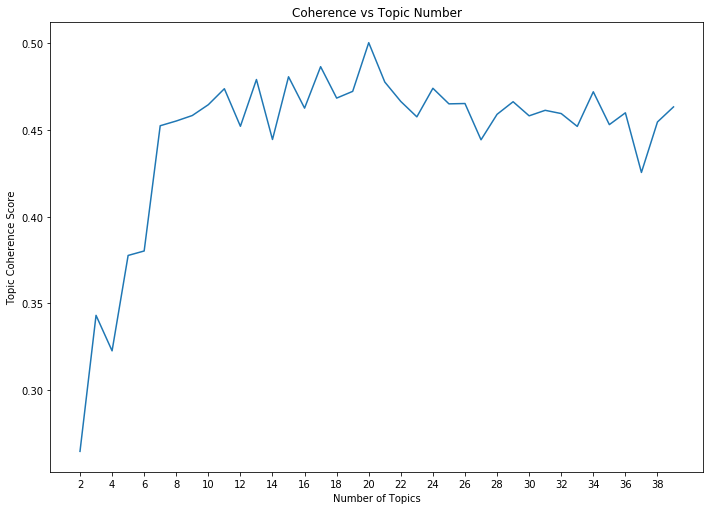

In [268]:
# Show graph
limit=40; start=2; step=1;
x = range(start, limit, step)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

ax.plot(x, coherence_values2)
plt.xlabel("Number of Topics")
plt.ylabel("Topic Coherence Score")
plt.title("Coherence vs Topic Number")
# #plt.legend(("coherence_values"), loc='best')
plt.xticks(np.arange(min(x), max(x)+1, 2))
plt.savefig("data/CoherenceVsTopicNumber.png")
plt.show()

In [269]:
# Print the coherence scores
for m, cv in zip(x, coherence_values2):
    print(m-2, ": Num Topics =", m, " has Coherence Value of", round(cv, 4))

0 : Num Topics = 2  has Coherence Value of 0.2646
1 : Num Topics = 3  has Coherence Value of 0.3431
2 : Num Topics = 4  has Coherence Value of 0.3226
3 : Num Topics = 5  has Coherence Value of 0.3776
4 : Num Topics = 6  has Coherence Value of 0.3802
5 : Num Topics = 7  has Coherence Value of 0.4525
6 : Num Topics = 8  has Coherence Value of 0.4552
7 : Num Topics = 9  has Coherence Value of 0.4584
8 : Num Topics = 10  has Coherence Value of 0.4646
9 : Num Topics = 11  has Coherence Value of 0.4738
10 : Num Topics = 12  has Coherence Value of 0.4522
11 : Num Topics = 13  has Coherence Value of 0.4791
12 : Num Topics = 14  has Coherence Value of 0.4445
13 : Num Topics = 15  has Coherence Value of 0.4807
14 : Num Topics = 16  has Coherence Value of 0.4626
15 : Num Topics = 17  has Coherence Value of 0.4866
16 : Num Topics = 18  has Coherence Value of 0.4684
17 : Num Topics = 19  has Coherence Value of 0.4723
18 : Num Topics = 20  has Coherence Value of 0.5004
19 : Num Topics = 21  has Cohe

In [270]:
coherence_values2[18]

0.5003963757093005

In [271]:
# Select the model and print the topics (15 topics)
optimal_model = model_list2[18]
model_topics = optimal_model.show_topics(formatted=False, num_words=20)
#pprint(optimal_model.print_topics(num_words=20))
model_topics

[(15,
  [('health', 0.021356275),
   ('drug', 0.017169613),
   ('patient', 0.014966376),
   ('hospital', 0.014058208),
   ('doctor', 0.013041544),
   ('medical', 0.012904156),
   ('death', 0.011811129),
   ('child', 0.011142593),
   ('die', 0.009480785),
   ('accord', 0.009249739),
   ('case', 0.007865488),
   ('marijuana', 0.0073963017),
   ('state', 0.0068260725),
   ('disease', 0.0068203076),
   ('care', 0.0067953654),
   ('virus', 0.006617869),
   ('treatment', 0.0065251878),
   ('physician', 0.0055279024),
   ('report', 0.005455626),
   ('colorado', 0.005275759)]),
 (12,
  [('woman', 0.03458775),
   ('white', 0.01401055),
   ('northam', 0.013049183),
   ('racist', 0.012259012),
   ('blackface', 0.012191094),
   ('state', 0.011485968),
   ('abortion', 0.010237206),
   ('statement', 0.009424654),
   ('page', 0.008444632),
   ('black', 0.008390697),
   ('law', 0.008121205),
   ('racism', 0.0074571944),
   ('female', 0.007386289),
   ('photo', 0.007292737),
   ('resign', 0.007125538),

In [272]:
coherencemodel = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')

In [273]:
# Save the LDA model:
optimal_model.save('models/2019_02_08_optimal_model.model')

In [275]:
# Load the LDA model:
optimal_model = gensim.models.LdaModel.load('models/2019_02_08_optimal_model.model')

In [287]:
#%%time
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
14     16.967859        1       1  0.222104 -0.108454
16     15.071903        1       2  0.251617  0.025783
18      7.851607        1       3  0.151558 -0.016349
7       6.701347        1       4  0.093344  0.128342
17      5.787199        1       5  0.098499  0.040748
2       4.770943        1       6  0.043750 -0.005906
13      4.596336        1       7  0.016400 -0.015725
19      4.455466        1       8  0.005103 -0.260473
1       4.399181        1       9  0.056243  0.185705
10      4.345098        1      10  0.055815 -0.063543
5       4.000088        1      11  0.048453 -0.012651
11      3.608763        1      12 -0.010723 -0.220757
3       3.424947        1      13  0.028628  0.177488
8       2.934253        1      14 -0.002574  0.074264
4       2.124388        1      15 -0.143707 -0.128264
15      2.073922        1      16 -0.123985  0.078032
12      1.956762        1      17 -0.126075  0.095335
0       1.949206        1      18 -0.202748  0.029589
9       1.543104        1      19 -0.218181  0.034683
6       1.437632        1      20 -0.243522 -0.037846, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
271    Default  14465.000000          say  14465.000000  30.0000  30.0000
1892   Default   2195.000000        trump   2195.000000  29.0000  29.0000
210    Default   3349.000000          not   3349.000000  28.0000  28.0000
53     Default   1694.000000      company   1694.000000  27.0000  27.0000
1496   Default   1815.000000    president   1815.000000  26.0000  26.0000
1751   Default   1283.000000        woman   1283.000000  25.0000  25.0000
744    Default   3684.000000        would   3684.000000  24.0000  24.0000
416    Default   3516.000000         year   3516.000000  23.0000  23.0000
352    Default   1870.000000           do   1870.000000  22.0000  22.0000
477    Default   1448.000000   government   1448.000000  21.0000  21.0000
629    Default   1606.000000      country   1606.000000  20.0000  20.0000
228    Default   3083.000000       people   3083.000000  19.0000  19.0000
593    Default   2055.000000          use   2055.000000  18.0000  18.0000
1076   Default   2918.000000          get   2918.000000  17.0000  17.0000
1397   Default   1111.000000       police   1111.000000  16.0000  16.0000
3564   Default    778.000000       russia    778.000000  15.0000  15.0000
1043   Default   1873.000000        state   1873.000000  14.0000  14.0000
2426   Default    979.000000        child    979.000000  13.0000  13.0000
140    Default   2729.000000           go   2729.000000  12.0000  12.0000
47     Default    860.000000         city    860.000000  11.0000  11.0000
259    Default   2061.000000       report   2061.000000  10.0000  10.0000
26     Default   1481.000000           be   1481.000000   9.0000   9.0000
764    Default    775.000000     facebook    775.000000   8.0000   8.0000
829    Default    667.000000         user    667.000000   7.0000   7.0000
694    Default    850.000000         post    850.000000   6.0000   6.0000
350    Default    663.000000        datum    663.000000   5.0000   5.0000
395    Default   1433.000000         show   1433.000000   4.0000   4.0000
3334   Default    515.000000         film    515.000000   3.0000   3.0000
270    Default   1698.000000            s   1698.000000   2.0000   2.0000
2949   Default    754.000000         game    754.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
5411   Topic20     46.777279  replacement     47.728848   4.2220  -5.5269
1108   Topic20     46.557571        tesla     47.509140   4.2219  -5.5316
5666   Topic20     44.731625          dip     45.683193   4.2211  -5.5716
4376   Topic20     44.266315       wilson     45.217884   4.2209  -5.5820
4911   Topic20     43.345272   

In [ ]:
%%time
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [207]:
test_url = 'https://www.bbc.co.uk/news/uk-47063009'
test_url = 'https://www.rt.com/news/450875-china-nuclear-aircraft-carriers/'
test_url = 'https://www.rt.com/usa/450846-nbc-rt-hunt-tulsi/'
test_url = 'https://www.rt.com/business/450243-iran-eu-transaction-channel/'
test_url = 'https://www.cnn.com/2018/10/03/media/next-popular-tv-show/index.html'
test_url = 'https://www.nbcnews.com/politics/congress/bipartisan-venezuela-legislation-fizzles-over-use-military-force-n968581'
test_url = 'https://www.nbcnews.com/business/economy/trump-touts-thriving-steel-industry-manufacturing-insiders-disagree-n954866'
test_url = 'https://www.rt.com/news/450205-castles-disney-turkey-video/'
test_url = 'https://www.rt.com/news/450329-usa-inf-treaty-russia-arms/'
extractArticlePublishedDate(test_url)

Extracting date from https://www.rt.com/news/450329-usa-inf-treaty-russia-arms/


datetime.datetime(2019, 2, 8, 6, 18, tzinfo=tzutc())

In [180]:
df_master[(df_master.source == 'rt') & (df_master.rss_published_parsed.notnull())]#.publish_date

,article_html,authors,canonical_link,html,keywords,meta_data,meta_description,meta_keywords,movies,paper_section_name,...,rss_published_parsed,rss_title,source,source_detail,source_url,summary,tags,text,title,url
3048,NaN,[],https://www.rt.com/news/450205-castles-disney-...,"<!DOCTYPE html>\n<html prefix=""og: http://ogp....",[],"defaultdict(<type 'dict'>, {'description': 'Hu...","Hundreds of chateaux, seemingly plucked out of...",[''],[],rt_main_page,...,"time.struct_time(tm_year=2019, tm_mon=1, tm_md...",Eerie DRONE VIDEO shows 580+ abandoned Disney-...,rt,rt_main_page,https://www.rt.com/,NaN,set([u'Turkey news']),"Hundreds of chateaux, seemingly plucked out of...",Eerie DRONE VIDEO shows 580+ abandoned Disney-...,https://www.rt.com/news/450205-castles-disney-...


In [129]:
df_master[df_master.canonical_link.isnull()]['canonical_link']

3048    NaN
Name: canonical_link, dtype: object

### Force download and parsing of articles that we failed to capture

In [39]:
df2.loc[838, 'url']

'https://www.cnn.com/2017/07/24/asia/return-to-cambodia-sex-trafficking/index.html'

In [41]:
article = Article(df2.loc[838, 'url'])

In [47]:
article.download()

In [50]:
article.parse()

In [51]:
article.text

'Svay Pak, Cambodia (CNN) Sephak was aged just 13 years old when she was sold for sex by her mother.\n\nShe was taken to a hospital, issued a certificate confirming her virginity, and then taken to a hotel room where a she was raped for days. She was returned home after three nights.\n\nSephak grew up in Svay Pak, a poor fishing village on the outskirts of the Cambodian capital of Phnom Penh. It\'s a community that has become notorious as a place to buy child sex.\n\nHer mother, Ann, said her family had fallen on hard times and that they took out a loan that eventually spiraled to about $6,000 in debt. With money-lenders threatening her, Ann took up an offer from a woman who approached her promising big money for her daughter\'s virginity.\n\nSephak said her mother was paid $800. But after Sephak\'s return, her mother began pressuring her to work in a brothel.\n\nAnn said she regrets her decision and that if she had known then what she knows now, she would never have sold her daughter.